In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

random_seed = 1337
np.random.seed(random_seed)

In [3]:
len(df['image_url'].unique())

63984

In [6]:
from keras.preprocessing.image import ImageDataGenerator

i=100

#will be used for validating our images
valid_generator = ImageDataGenerator(rescale = 1./255)

valid_gen = valid_generator.flow_from_directory('../data/data/valid',
                                      target_size = (64, 64),
                                      batch_size = 32,
                                      class_mode = 'binary',
                                      seed = random_seed)

#will be used only for our train data
test_generator = ImageDataGenerator(rescale = 1./255)

test_gen = test_generator.flow_from_directory('../data/data/test',
                                      target_size = (64, 64),
                                      batch_size = 32,
                                      class_mode = 'binary',
                                      seed = random_seed)

#generates new training images with geometric transformations
train_generator = ImageDataGenerator(rescale = 1./255,
                                     horizontal_flip = True,
                                     rotation_range = 20,
                                     zoom_range = 0.3,
                                     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                     height_shift_range=0.1,) #randomly shift images vertically

train_gen = train_generator.flow_from_directory('../data/data/train',
                                      target_size = (64, 64),
                                      batch_size = 128,
                                      class_mode = 'binary',
                                      seed = random_seed)

Found 2000 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.
Found 9663 images belonging to 2 classes.


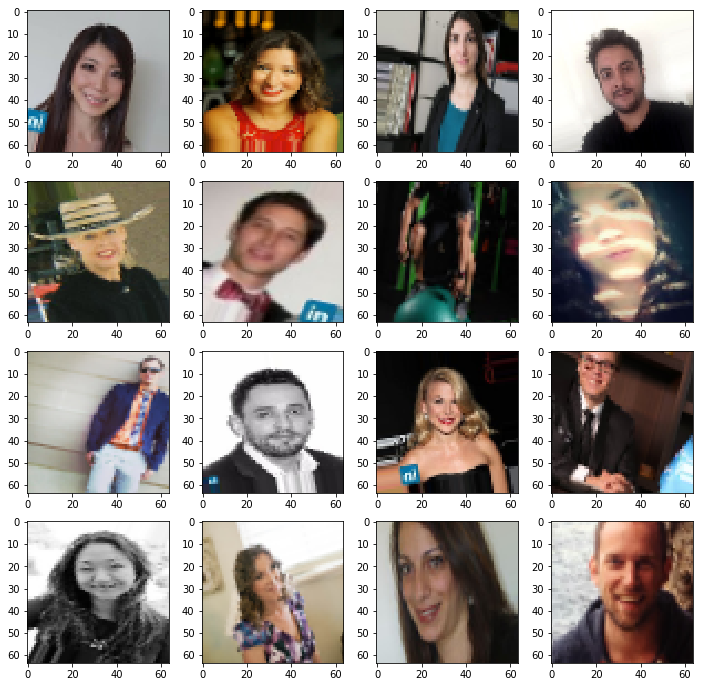

In [7]:
import datetime

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

regularization = 'l2'
fit_steps = 200

def build_inception_module(input_layer, features_nr):
    tower_1 = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization)(input_layer)
    tower_1 = Conv2D(features_nr, (3,3), padding='same', activation='relu',
                    kernel_regularizer=regularization)(tower_1)
    tower_1 = BatchNormalization()(tower_1)

    tower_2 = Conv2D(features_nr, (1,1), padding='same', activation='relu',
                    kernel_regularizer=regularization)(input_layer)
    tower_2 = Conv2D(features_nr, (3,3), padding='same', activation='relu',
                    kernel_regularizer=regularization)(tower_2)
    tower_2 = Conv2D(features_nr, (3,3), padding='same', activation='relu',
                    kernel_regularizer=regularization)(tower_2)
    tower_2 = BatchNormalization()(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    tower_3 = Conv2D(features_nr, (1,1), padding='same', activation='relu',
                    kernel_regularizer=regularization)(tower_3)
    tower_3 = BatchNormalization()(tower_3)

    tower_4 = Conv2D(features_nr, (1,1), padding='same', activation='relu',
                    kernel_regularizer=regularization)(input_layer)
    tower_4 = BatchNormalization()(tower_4)

    output = concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)

    pooled = MaxPooling2D((2,2), padding='same')(output)
    
    return pooled

i=datetime.datetime.now().strftime("%I:%M%p-%B %d-%Y")

K.clear_session()

a = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_acc', filepath='../models/man-woman-'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./man-woman-logs/'+str(i), 
                histogram_freq=1,
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[b,c,d]

max_epochs = 50
lrate = 0.001
decay = lrate/max_epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

input_img = Input(shape = (64, 64, 3))

inception_1 = build_inception_module(input_img, 9)

#conv_2 = Conv2D(72, (3,3), padding='same', activation='relu')(inception_1)
#conv_2 = BatchNormalization()(conv_2)

#pooled_2 = MaxPooling2D((2,2), padding='same')(conv_2)

inception_2 = build_inception_module(inception_1, 72)

#55=x5 convolution
conv_3 = Conv2D(144, (3,3), padding='same', activation='relu', kernel_regularizer=regularization)(inception_2)
conv_3 = Conv2D(144, (3,3), padding='valid', activation='relu', kernel_regularizer=regularization)(conv_3)
conv_3 = BatchNormalization()(conv_3)

pooled_3 = MaxPooling2D((2,2), padding='same')(conv_3)

conv_4 = Conv2D(288, (3,3), padding='same', activation='relu', kernel_regularizer=regularization)(pooled_3)
conv_4 = BatchNormalization()(conv_4)

pooled_4 = MaxPooling2D((2,2), padding='same')(conv_4)

#inception_3 = build_inception_module(inception_2, 552)

flat = Flatten()(pooled_4)

dense = Dense(128, kernel_regularizer=regularization)(flat)
dense = BatchNormalization()(dense)

drop = Dropout(0.5)(dense)

dense_2 = Dense(64, kernel_regularizer=regularization)(drop)
dense_2 = BatchNormalization()(dense_2)

drop_2 = Dropout(0.5)(dense_2)

out = Dense(1, activation='sigmoid')(drop_2)

with tf.device('/cpu:0'):
    model = Model(inputs = input_img, outputs = out)

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lrate),
                  metrics=['accuracy'])

    model.summary()

model_json = model.to_json()
with open("../models/man-woman-'+str(i)+'.json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to" + "../models/man-woman-"+str(i)+".json")



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 9)    36          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 9)    36          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 9)    738         conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_poolin

|Model architecture | Optimizer | Batch | Train images | Stop epoch | Test accuracy |
|------------- |---|-------------|----|
|4 x (conv+max pool) flt dsn dr act (w batch normalization)|SGD l=0.01 decay=0.01/50 nest=False|128|Normalized color + augmentation|5|72.53 %
|4 x (conv+max pool) flt dsn dr act (w batch normalization)|SGD l=0.01 decay=0.01/50 nest=False|128|Normalized color + augmentation|15|76.68 %
|1 x inception pool3x3 flt dsn dr act (w batch normalization)|SGD l=0.01 decay=0.01/50 nest=False|128|Normalized color + augmentation|28|74.10%(validation)
|1 x inception pool3x3 batch_norm flt dsn dr act(w batch normalization) |SGD l=0.01 decay=0.01/50 nest=False|128|Normalized color + augmentation|28|69.11 %
|1 x inception pool3x3 2x(conv+pool) flt dns dr dns dr act (w batch normalization)|adam default|128|Normalized color + augmentation|19|75.38 %
|1 x inception pool3x3 2x(conv+pool) flt dns dr act (w batch normalization)|adam default|128|Normalized color + augmentation|19|78.12 %
|2 x inception (conv+pool) (conv+pool) flt dns(64) dr(0.5) act (w batch normalization)|adam default|128|Normalized color + augmentation|19|80.03 %
|2 x inception (conv+pool) (conv+pool)  flt dns(64) dr(0.5) act (w batch normalization)|adam default|128|Normalized color|20|78.66 % (overfit to train set)
|2 x inception (conv+pool) (conv+pool)  flt dns(64) dr(0.5) act (w batch normalization)|adam l=0.001 decay=0.001/50|128|Normalized color|20|77.50 % (overfit to train set)
|2 x inception 2 x (conv+pool) flt dns(128) dr(0.5) dns(64) dr(0.5) act (w batch normalization)|adam l=0.001 decay=0.001/50|128|Normalized color|20|75.68 % (overfit to train set)
|2 x inception 2 x (conv+pool) flt dns(128) dr(0.5) dns(64) dr(0.5) act (w batch normalization + regularization)|adam l=0.001|128|Normalized color + augmented(h_flip, rot, zoom)|41|85.99 %

In [ ]:
model.fit_generator(train_gen, 
                    epochs=max_epochs, 
                    steps_per_epoch=fit_steps,
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_data=valid_gen)

Epoch 1/50
200/200 [==============================] - 362s 2s/step - loss: 6.0128 - acc: 0.6862 - val_loss: 2.1857 - val_acc: 0.5435

Epoch 00001: val_acc improved from -inf to 0.54350, saving model to ../models/man-woman-09:17AM-June 24-2018.hdf5
Epoch 2/50
200/200 [==============================] - 389s 2s/step - loss: 1.2186 - acc: 0.7652 - val_loss: 1.0612 - val_acc: 0.6075

Epoch 00002: val_acc improved from 0.54350 to 0.60750, saving model to ../models/man-woman-09:17AM-June 24-2018.hdf5
Epoch 3/50
200/200 [==============================] - 390s 2s/step - loss: 0.7788 - acc: 0.7895 - val_loss: 0.7441 - val_acc: 0.7855

Epoch 00003: val_acc improved from 0.60750 to 0.78550, saving model to ../models/man-woman-09:17AM-June 24-2018.hdf5
Epoch 4/50
200/200 [==============================] - 390s 2s/step - loss: 0.6532 - acc: 0.8060 - val_loss: 0.7810 - val_acc: 0.6720

Epoch 00004: val_acc did not improve from 0.78550
Epoch 5/50
200/200 [==============================] - 389s 2s/step

In [8]:
model.load_weights("../models/man-woman-09:17AM-June 24-2018.hdf5")

In [ ]:
import tensorflow as tf

with tf.device('/cpu:0'):
    results = model.evaluate_generator(test_gen, verbose=1)
    print("Accuracy {0:.2f} %".format(results[1]*100))